# Save and restart a WorkGraph

## Introduction
`WorkGraph` supports save and load a WorkGraph and modify the workflow, then submit the job again. WorkGraph save its data as a extra attribute into its process, so that one can rebuild the WorkGraph from the process.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='10014391ebf5492db57a6edfea62c68e' name='default'>

## Create a WorkGraph

In [2]:
from aiida_workgraph import task
from aiida.engine import calcfunction

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

from aiida_workgraph import WorkGraph
from aiida.orm import Int
x = Int(2.0)
y = Int(3.0)
z = Int(4.0)

wg = WorkGraph("first_workflow")
wg.tasks.new(add, name="add1", x=x, y=y)
wg.tasks.new(add, name="add2", x=x, y=y)
wg.tasks.new(add, name="add3", x=x, y=y)
wg.links.new(wg.tasks["add1"].outputs[0], wg.tasks["add2"].inputs["x"])
wg.links.new(wg.tasks["add2"].outputs[0], wg.tasks["add3"].inputs["x"])

wg.submit(wait=True)

WorkGraph process crated, PK: 11042


Check the state and pk of the workgraph:

In [3]:
!verdi process status {wg.process.pk}
print('Result of add3      : {}'.format(wg.tasks["add3"].outputs["result"].value))


WorkGraph: first_workflow<11042> Finished [0]
    ├── add<11043> Finished [0]
    ├── add<11045> Finished [0]
    └── add<11047> Finished [0]
Result of add3      : 11


## Load the WorkGraph and restart
Now, we modify the `add2` task, and re-submit the workgraph. Use the `load` method to load a WorkGraph from a process, then use the `restart` flag to restart the workflow

In [4]:
from aiida_workgraph import WorkGraph
wg2 = WorkGraph.load(wg.pk)
wg2.name = "restart_workflow"
wg2.tasks["add2"].set({"y": Int(10).store()})
# use the `restart` flag to restart the workflow
wg2.submit(wait=True, restart=True)

WorkGraph process crated, PK: 11050
key y changes
modified_nodes: {'add2'}


### Check status and results
Since we only modify the `add2` task, so the `add2` and its child task `add3` will re-run.

In [5]:
!verdi process status {wg2.process.pk}
print('Result of add3      : {}'.format(wg2.tasks["add3"].outputs["result"].value))


WorkGraph: restart_workflow<11050> Finished [0]
    ├── add<11051> Finished [0]
    └── add<11053> Finished [0]
Result of add3      : 18


Generate node graph from the AiiDA process:

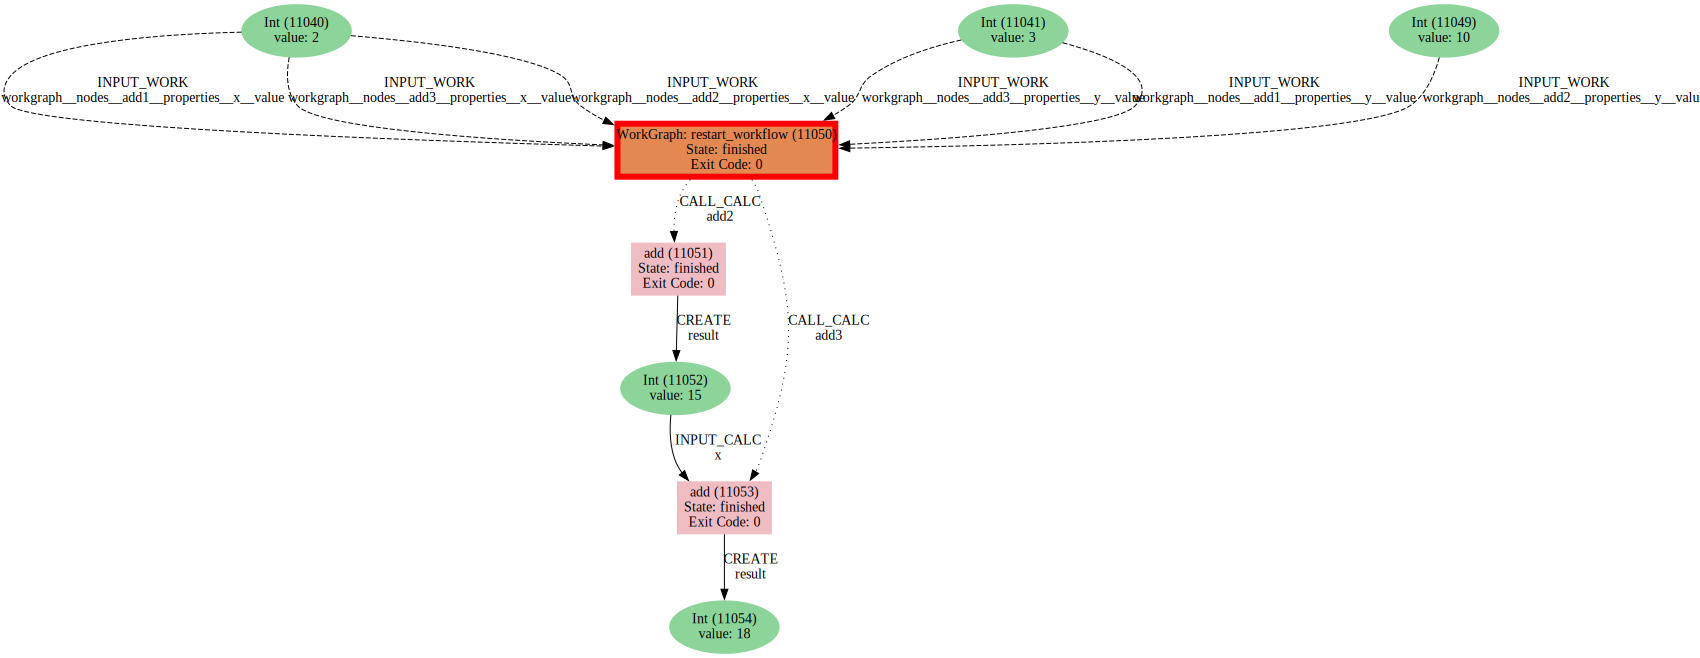

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg2.pk)